## 掛接 Google Drive

In [16]:
# connect to your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
%cd '/content/drive/MyDrive/Colab Notebooks/2022cvdl_practice_HW3'

/content/drive/MyDrive/Colab Notebooks/2022cvdl_practice_HW3


In [18]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2

## 載入資料

In [19]:
# 確認壓縮檔路徑
filepath='/content/drive/MyDrive/Colab Notebooks/2022cvdl_practice_HW3'
os.listdir(filepath)

['sample_submission.csv',
 'category.xlsx',
 'stanford_dogs.zip',
 'CILSHW3.ipynb',
 'stanfor_dogs',
 'prediction_v1.csv',
 'prediction_v2.csv',
 'prediction_v3.csv',
 'prediction_v4.csv',
 'prediction_v5.csv',
 'prediction_v6.csv',
 'F44076241_水修澤_HW3.ipynb',
 'prediction_v7.csv',
 'prediction_v8.csv',
 'model.png',
 'prediction_v9.csv',
 'Copy of F44076241_水修澤_HW3.ipynb']

In [20]:
# 解壓縮檔案
# !unzip '/content/drive/MyDrive/Colab Notebooks/2022cvdl_practice_HW3/stanford_dogs.zip' -d '/content/drive/MyDrive/Colab Notebooks/2022cvdl_practice_HW3'

In [21]:
dirpath='/content/drive/MyDrive/Colab Notebooks/2022cvdl_practice_HW3/stanfor_dogs/'
os.listdir(dirpath) 

['train', 'test']

In [22]:
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

imgSize=(224,224)
imgShape=(224,224,3)
batchSize=64

# train generator
trainDataGenerator = ImageDataGenerator(rescale = 1/255,
                      # augmentation
                      rotation_range = 40,
                      width_shift_range = 0.2,
                      height_shift_range = 0.2,
                      shear_range = 0.3,
                      zoom_range = 0.2,
                      horizontal_flip = True,
                      validation_split=0.3)
valDataGenerator = ImageDataGenerator(rescale=1/255,validation_split=0.3)

trainBatch = trainDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='training'
)

valBatch = valDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='validation'
)

# test generator
testDataGenerator = ImageDataGenerator(rescale=1/255)

testBatch = testDataGenerator.flow_from_directory(
    dirpath,
    class_mode=None,
    batch_size=1,
    shuffle = False,
    target_size= imgSize,
    classes=['test']
)


Found 8400 images belonging to 120 classes.
Found 3600 images belonging to 120 classes.
Found 8580 images belonging to 1 classes.


## 載入模型

In [35]:
# Build Model Using Pre-trained Model

from keras import models
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

# load InceptionV3 pre-trained model
base_model = InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

model = models.Sequential()
model.add(base_model) # add pre_trained layers
model.add(GlobalAveragePooling2D())
#model.add(Flatten()) # flatten to 1-D vector to prepare for fully connected layers
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(120, activation = 'softmax'))

# Freeze pre-trained layers
model.layers[0].trainable = False

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               786944    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 120)              

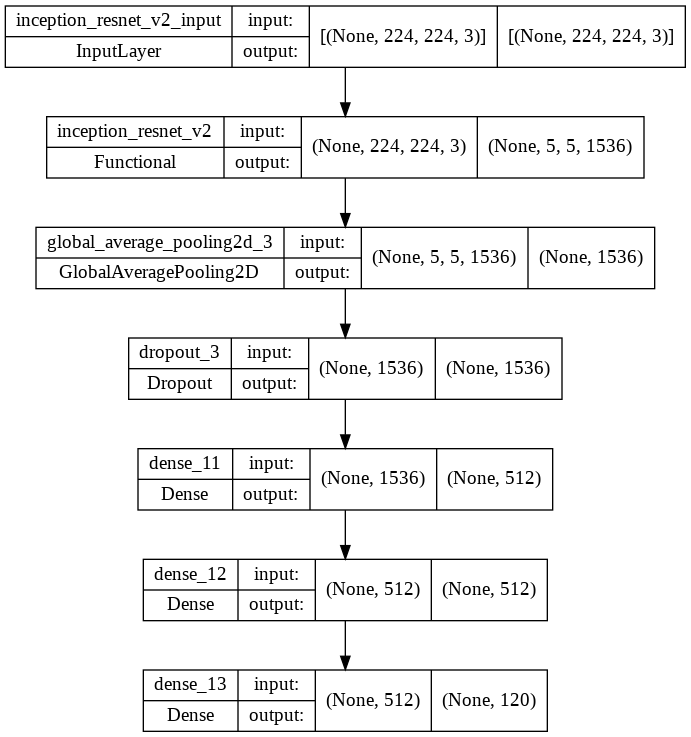

In [37]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## train model

In [38]:
# GPU acceleration
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!nvidia-smi

Found GPU at: /device:GPU:0
Mon May 23 06:21:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |   8938MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [39]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# Train Model

epoch=12
history = model.fit_generator(
  trainBatch,
  steps_per_epoch = trainBatch.samples // batchSize,
  validation_data = valBatch,
  validation_steps = valBatch.samples // batchSize,
  epochs=epoch,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/12
131/131 [==============================] - 146s 1s/step - loss: 3.2848 - accuracy: 0.4135 - val_loss: 0.7328 - val_accuracy: 0.8619
Epoch 2/12
131/131 [==============================] - 132s 1s/step - loss: 0.9574 - accuracy: 0.7546 - val_loss: 0.4154 - val_accuracy: 0.8747
Epoch 3/12
131/131 [==============================] - 133s 1s/step - loss: 0.7867 - accuracy: 0.7724 - val_loss: 0.3876 - val_accuracy: 0.8836
Epoch 4/12
131/131 [==============================] - 132s 1s/step - loss: 0.7370 - accuracy: 0.7872 - val_loss: 0.3848 - val_accuracy: 0.8856
Epoch 5/12
131/131 [==============================] - 133s 1s/step - loss: 0.7269 - accuracy: 0.7898 - val_loss: 0.3803 - val_accuracy: 0.8831
Epoch 6/12
131/131 [==============================] - 133s 1s/step - loss: 0.7015 - accuracy: 0.7911 - val_loss: 0.3784 - val_accuracy: 0.8839
Epoch 7/12
131/131 [==============================] - 133s 1s/step - loss: 0.6928 - accuracy: 0.7967 - val_loss: 0.3737 - val_accuracy: 0.8862

## show the loss & accuracy curve

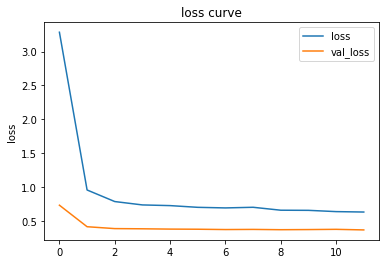

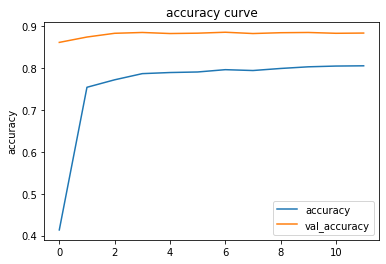

In [41]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## predict test data

In [42]:
prediction = model.predict(testBatch)
prediction

array([[1.74931301e-05, 2.74515036e-03, 9.90797271e-05, ...,
        1.25953120e-05, 1.12935151e-04, 1.85532372e-05],
       [9.48590969e-05, 9.96644735e-01, 2.00102004e-05, ...,
        4.38893903e-06, 3.30044277e-05, 7.68560585e-06],
       [1.01106634e-05, 1.00479920e-05, 1.14272789e-05, ...,
        1.37675715e-05, 1.35956245e-04, 2.44085059e-05],
       ...,
       [1.00766185e-04, 8.34082221e-06, 4.41974271e-06, ...,
        1.91999152e-05, 1.91475101e-05, 2.67924897e-05],
       [1.79547751e-05, 2.33870287e-06, 1.45140348e-05, ...,
        9.24936194e-06, 4.53846806e-05, 1.46230568e-05],
       [1.08441118e-05, 7.21884680e-06, 5.51376570e-06, ...,
        1.27894828e-05, 9.60005636e-05, 2.16807493e-05]], dtype=float32)

## 輸出結果

In [43]:
import pandas as pd
prediction_label=prediction.argmax(axis=1)
filename=testBatch.filenames
filename_new = []
for f in filename:
  filename_new.append(f[5::])

In [44]:
outputdf=pd.DataFrame()
outputdf['Name']=filename_new
outputdf['Label']=prediction_label
outputdf.to_csv('/content/drive/MyDrive/Colab Notebooks/2022cvdl_practice_HW3/prediction_v10.csv',index=False)